# Imports

In [32]:
# Numerai API
from numerapi import NumerAPI

# data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# stats
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error

# machine learning models
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# other
import gc
import json
from tqdm import trange
from copy import deepcopy
from datetime import datetime
from tqdm import tqdm

# save variables
import joblib

# my utils
from utils import *

# Download data

In [33]:
napi = NumerAPI()
round = napi.get_current_round()
era = round + 695

napi.download_dataset('v4/features.json', 'data/features.json')
napi.download_dataset('v4/train_int8.parquet', 'data/train.parquet')
napi.download_dataset('v4/validation_int8.parquet', 'data/validation.parquet')
napi.download_dataset('v4/live_int8.parquet', f'data/live_{round}.parquet')

2022-08-06 15:34:32,241 INFO numerapi.utils: target file already exists
2022-08-06 15:34:32,241 INFO numerapi.utils: download complete
2022-08-06 15:34:33,234 INFO numerapi.utils: target file already exists
2022-08-06 15:34:33,237 INFO numerapi.utils: download complete
2022-08-06 15:34:34,890 INFO numerapi.utils: target file already exists
2022-08-06 15:34:34,893 INFO numerapi.utils: download complete
2022-08-06 15:34:35,905 INFO numerapi.utils: target file already exists
2022-08-06 15:34:35,908 INFO numerapi.utils: download complete


# CV 1: Era / Feature subsampling

In [34]:
# params = {
#     'n_estimators': 2000,
#     'learning_rate': 0.01,
#     'max_depth': 5,
#     'num_leaves': 2**5,
#     'colsample_bytree': 0.1,
#     'device': 'gpu',
# }

# param_grid = {
#     'estimator__n_features_per_group': [0, 208],
#     'n_subsamples': [1, 4],
# }

# model = LGBMRegressor(**params)
# model = FeatureSubsampler(model, n_features_per_group=0)
# model = EraSubsampler(model, n_subsamples=1)

# gs = GridSearchCV(model, param_grid, cv=TimeSeriesSplitGroups(5))

In [35]:
# df = pd.read_parquet('data/train.parquet', columns=COLUMNS)
# df[ERA] = df[ERA].astype('int32')

# X_COLS = FEAT_L

# X = df[X_COLS]
# y = df[Y_TRUE]
# e = df[ERA]

# del df
# gc.collect()

# spl = TimeSeriesSplitGroups()

## no feature subsampling, no era subsampling

In [36]:
# model = LGBMRegressor(**params)

# x_eras = np.arange(e.min(), e.max() + 1)
# y_corr = np.zeros(e.max() + e.min() - 1, dtype=float)

# e_val_min = []
# c_val = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     print('\tdefining X, y, e')
#     X_trn = X.iloc[trn]
#     X_val = X.iloc[val]
#     y_trn = y.iloc[trn]
#     y_val = y.iloc[val]
#     e_trn = e.iloc[trn] # ; print(f'e_trn_min = {e_trn.min()}, e_trn_max = {e_trn.max()}')
#     e_val = e.iloc[val] # ; print(f'e_val_min = {e_val.min()}, e_val_max = {e_val.max()}')

#     print('\ttraining model')
#     model.fit(X_trn, y_trn)

#     print('\tcomputing predictions')
#     # y_trn_pred = model.predict(X_trn)
#     y_val_pred = model.predict(X_val)

#     print('\tcomputing correlations')
#     # corr_trn = corr(y_trn, y_trn_pred, rank_b=e_trn)
#     corr_val = corr(y_val, y_val_pred, rank_b=e_val)

#     for era in e_val.unique():
#         y_era_true = y[e==era]
#         y_era_pred = pd.DataFrame(e_val)
#         y_era_pred['y_val_pred'] = y_val_pred
#         y_era_pred = y_era_pred[e_val==era]
#         y_era_pred = y_era_pred['y_val_pred']
#         c = corr(y_era_true, y_era_pred)
#         y_corr[era - 1] = c
    
#     e_val_min.append(e_val.min())
#     c_val.append(corr_val)

#     # break

# cr = np.mean(c_val)

In [37]:
# fig, ax = plt.subplots()
# ax.axhline(cr, color='green', linestyle='--')
# ax.axhline(0, color='black', linewidth=1)
# # ax.ytick
# for e in e_val_min:
#     ax.axvline(e, color='gray', linestyle='--')
# ax.plot(x_eras, y_corr)
# ax.set_xlabel('era')
# ax.set_ylabel('corr')
# ax.set_title(f'no feature or era subsampling. corr = {cr:.4f}')

## no feature subsampling, with era subsampling

In [38]:
# model = LGBMRegressor(**params)
# model = EraSubsampler(model)

# x_eras = np.arange(e.min(), e.max() + 1)
# y_corr = np.zeros(e.max() + e.min() - 1, dtype=float)

# e_val_min = []
# c_val = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     print('\tdefining X, y, e')
#     X_trn = X.iloc[trn]
#     X_val = X.iloc[val]
#     y_trn = y.iloc[trn]
#     y_val = y.iloc[val]
#     e_trn = e.iloc[trn] # ; print(f'e_trn_min = {e_trn.min()}, e_trn_max = {e_trn.max()}')
#     e_val = e.iloc[val] # ; print(f'e_val_min = {e_val.min()}, e_val_max = {e_val.max()}')

#     print('\ttraining model')
#     model.fit(X_trn, y_trn, eras=e_trn)

#     print('\tcomputing predictions')
#     # y_trn_pred = model.predict(X_trn)
#     y_val_pred = model.predict(X_val)

#     print('\tcomputing correlations')
#     # corr_trn = corr(y_trn, y_trn_pred, rank_b=e_trn)
#     corr_val = corr(y_val, y_val_pred, rank_b=e_val)

#     for era in e_val.unique():
#         y_era_true = y[e==era]
#         y_era_pred = pd.DataFrame(e_val)
#         y_era_pred['y_val_pred'] = y_val_pred
#         y_era_pred = y_era_pred[e_val==era]
#         y_era_pred = y_era_pred['y_val_pred']
#         c = corr(y_era_true, y_era_pred)
#         y_corr[era - 1] = c
    
#     e_val_min.append(e_val.min())
#     c_val.append(corr_val)

#     # break

# cr = np.mean(c_val)

In [39]:
# fig, ax = plt.subplots()
# ax.axhline(cr, color='green', linestyle='--')
# ax.axhline(0, color='black', linewidth=1)
# # ax.ytick
# for e in e_val_min:
#     ax.axvline(e, color='gray', linestyle='--')
# ax.plot(x_eras, y_corr)
# ax.set_xlabel('era')
# ax.set_ylabel('corr')
# ax.set_title(f'no feature or era subsampling. corr = {cr:.4f}')

## with feature subsampling, no era subsampling

In [40]:
# model = LGBMRegressor(**params)
# model = FeatureSubsampler(model)

# x_eras = np.arange(e.min(), e.max() + 1)
# y_corr = np.zeros(e.max() + e.min() - 1, dtype=float)

# e_val_min = []
# c_val = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     print('\tdefining X, y, e')
#     X_trn = X.iloc[trn]
#     X_val = X.iloc[val]
#     y_trn = y.iloc[trn]
#     y_val = y.iloc[val]
#     e_trn = e.iloc[trn] # ; print(f'e_trn_min = {e_trn.min()}, e_trn_max = {e_trn.max()}')
#     e_val = e.iloc[val] # ; print(f'e_val_min = {e_val.min()}, e_val_max = {e_val.max()}')

#     print('\ttraining model')
#     model.fit(X_trn, y_trn)

#     print('\tcomputing predictions')
#     # y_trn_pred = model.predict(X_trn)
#     y_val_pred = model.predict(X_val)

#     print('\tcomputing correlations')
#     # corr_trn = corr(y_trn, y_trn_pred, rank_b=e_trn)
#     corr_val = corr(y_val, y_val_pred, rank_b=e_val)

#     for era in e_val.unique():
#         y_era_true = y[e==era]
#         y_era_pred = pd.DataFrame(e_val)
#         y_era_pred['y_val_pred'] = y_val_pred
#         y_era_pred = y_era_pred[e_val==era]
#         y_era_pred = y_era_pred['y_val_pred']
#         c = corr(y_era_true, y_era_pred)
#         y_corr[era - 1] = c
    
#     e_val_min.append(e_val.min())
#     c_val.append(corr_val)

#     # break

# cr = np.mean(c_val)

In [41]:
# fig, ax = plt.subplots()
# ax.axhline(cr, color='green', linestyle='--')
# ax.axhline(0, color='black', linewidth=1)
# # ax.ytick
# for e in e_val_min:
#     ax.axvline(e, color='gray', linestyle='--')
# ax.plot(x_eras, y_corr)
# ax.set_xlabel('era')
# ax.set_ylabel('corr')
# ax.set_title(f'no feature or era subsampling. corr = {cr:.4f}')

## with feature subsampling and era subsampling

In [42]:
# model = LGBMRegressor(**params)
# model = FeatureSubsampler(model)
# model = EraSubsampler(model)

# x_eras = np.arange(e.min(), e.max() + 1)
# y_corr = np.zeros(e.max() + e.min() - 1, dtype=float)

# e_val_min = []
# c_val = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     print('\tdefining X, y, e')
#     X_trn = X.iloc[trn]
#     X_val = X.iloc[val]
#     y_trn = y.iloc[trn]
#     y_val = y.iloc[val]
#     e_trn = e.iloc[trn] # ; print(f'e_trn_min = {e_trn.min()}, e_trn_max = {e_trn.max()}')
#     e_val = e.iloc[val] # ; print(f'e_val_min = {e_val.min()}, e_val_max = {e_val.max()}')

#     print('\ttraining model')
#     model.fit(X_trn, y_trn, eras=e_trn)

#     print('\tcomputing predictions')
#     # y_trn_pred = model.predict(X_trn)
#     y_val_pred = model.predict(X_val)

#     print('\tcomputing correlations')
#     # corr_trn = corr(y_trn, y_trn_pred, rank_b=e_trn)
#     corr_val = corr(y_val, y_val_pred, rank_b=e_val)

#     for era in e_val.unique():
#         y_era_true = y[e==era]
#         y_era_pred = pd.DataFrame(e_val)
#         y_era_pred['y_val_pred'] = y_val_pred
#         y_era_pred = y_era_pred[e_val==era]
#         y_era_pred = y_era_pred['y_val_pred']
#         c = corr(y_era_true, y_era_pred)
#         y_corr[era - 1] = c
    
#     e_val_min.append(e_val.min())
#     c_val.append(corr_val)

#     # break

# cr = np.mean(c_val)

In [43]:
# fig, ax = plt.subplots()
# ax.axhline(cr, color='green', linestyle='--')
# ax.axhline(0, color='black', linewidth=1)
# # ax.ytick
# for e in e_val_min:
#     ax.axvline(e, color='gray', linestyle='--')
# ax.plot(x_eras, y_corr)
# ax.set_xlabel('era')
# ax.set_ylabel('corr')
# ax.set_title(f'no feature or era subsampling. corr = {cr:.4f}')

# CV 2: targets

## just average

In [44]:
# params = {
#     'n_estimators': 2000,
#     'learning_rate': 0.01,
#     'max_depth': 5,
#     'num_leaves': 2**5,
#     'colsample_bytree': 0.1,
#     'device': 'gpu',
# }

# df = pd.read_parquet('data/train.parquet', columns=COLUMNS)
# df[ERA] = df[ERA].astype('int32')
# df = df.fillna(0.5)

# X_COLS = FEAT_L

# X = df[X_COLS]
# y = df[Y_COLS]
# e = df[ERA]

# del df
# gc.collect()

# spl = TimeSeriesSplitGroups()

In [45]:
# # model = LGBMRegressor(**params)
# # model = EraSubsampler(model)
# # model = MultiTargetTrainer(model)

# from itertools import chain, combinations

# def nempty_subsets(iterable):
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# corr_dict = {
#     'subset': [],
#     'fold_1': [],
#     'fold_2': [],
#     'fold_3': [],
#     'fold_4': [],
#     'fold_5': [],
# }

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     X_val = X.iloc[val]
#     y_val = y[Y_TRUE].iloc[val]
#     e_val = e.iloc[val]
#     # X_trn = X.iloc[trn]
#     # y_trn = y.iloc[trn]
#     # e_trn = e.iloc[trn]

#     # print('\ttraining model')
#     # model.fit(X_trn, y_trn, eras=e_trn)
#     # joblib.dump(model, f'model-0/saved-variables/multi_target_fold_{i}.pkl')
#     model = joblib.load(f'model-0/saved-variables/multi_target_fold_{i}.pkl')

#     # print('\tcomputing predictions')
#     # y_val_pred = model.model.predict(X_val)
#     # joblib.dump(y_val_pred, f'model-0/saved-variables/y_val_pred_{i}.pkl')
#     y_val_pred = joblib.load(f'model-0/saved-variables/y_val_pred_{i}.pkl')

#     j = 0
#     for subset in nempty_subsets(range(10)):
#         j += 1
#         print(f'\r\tin iteration {j}/1023 of subsets', 
#               end=' '*len('        in iteration 1023/1023 of subsets'))

#         y_pred = np.average(y_val_pred[:, subset], axis=1)

#         c = corr(y_val, y_pred, rank_b=e_val)

#         corr_dict[f'fold_{i}'].append(c)
#         if i == 1:
#             corr_dict['subset'].append(subset)

# corr_df = pd.DataFrame(corr_dict)
# corr_df['avg'] = corr_df[['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']].mean(1)
# joblib.dump(corr_df, 'model-0/saved-variables/corr_df')

In [46]:
# # alternative: train linear model on (predictions of multitarget, true)
# # see if that generalizes better out of sample

# # model = LGBMRegressor(**params)
# # model = EraSubsampler(model)
# # model = MultiTargetTrainer(model)

# c_val = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     X_val = X.iloc[val]
#     X_trn = X.iloc[trn]
#     y_val = y.iloc[val]
#     y_trn = y.iloc[trn]
#     e_val = e.iloc[val]
#     e_trn = e.iloc[trn]

#     # print('\ttraining model')
#     # model.fit(X_trn, y_trn, eras=e_trn)
#     # joblib.dump(model, f'model-0/saved-variables/multi_target_fold_{i}.pkl')
#     model = joblib.load(f'model-0/saved-variables/multi_target_fold_{i}.pkl')
    
#     print('\tpredicting Y on training set')
#     y_trn_pred = model.predict(X_trn)
#     joblib.dump(y_trn_pred, f'model-0/saved-variables/y_trn_pred_{i}.pkl')

#     print('\ttraining linear regression on (Y_trn_pred, y_trn_true)')
#     aux_lin = LinearRegression()
#     aux_lin.fit(y_trn_pred, y_trn[Y_TRUE])
#     joblib.dump(aux_lin, f'model-0/saved-variables/aux_lin_{i}.pkl')

#     print('\tpredicting with linear regression & computing corr')
#     y_val_pred = joblib.load(f'model-0/saved-variables/y_val_pred_{i}.pkl')
#     y_val_pred_lr = aux_lin.predict(y_val_pred)

#     c = corr(y_val, y_val_pred_lr, rank_b=e_val)
#     c_val.append(c)


## train twice

In [47]:
# params = {
#     'n_estimators': 2000,
#     'learning_rate': 0.01,
#     'max_depth': 5,
#     'num_leaves': 2**5,
#     'colsample_bytree': 0.1,
#     'device': 'gpu',
# }

# df = pd.read_parquet('data/train.parquet', columns=COLUMNS)
# df[ERA] = df[ERA].astype('int32')
# df = df.fillna(0.5)
# df = df[df[ERA].isin(np.arange(1, 574, 4))]

# X_COLS = FEAT_L

# X = df[X_COLS]
# y = df[Y_COLS]
# e = df[ERA]

# del df
# gc.collect()

# spl = TimeSeriesSplitGroups(3)

In [48]:
# model = LGBMRegressor(**params)
# model = MultiOutputRegressor(model)

# corr_dict_fold = {
#     'corr_one': [],
#     'corr_lin': [],
#     'corr_lgb': [],
# }

# eras = np.arange(e.min(), e.max() + 1)

# corr_dict_era = {
#     'corr_one': np.zeros(e.max() + e.min() - 1, dtype=float),
#     'corr_lin': np.zeros(e.max() + e.min() - 1, dtype=float),
#     'corr_lgb': np.zeros(e.max() + e.min() - 1, dtype=float),
# }

# e_val_min = []

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     X_trn = X.iloc[trn]
#     X_val = X.iloc[val]
#     Y_trn = y.iloc[trn]
#     Y_val = y.iloc[val]
#     e_trn = e.iloc[trn]
#     e_val = e.iloc[val]
#     y_trn = Y_trn[Y_TRUE]
#     y_val = Y_val[Y_TRUE]

#     e_val_min.append(e_val.min())

#     print('\tmulti output')
#     print('\t\ttraining')
#     model.fit(X_trn, Y_trn)
#     print('\t\tpredicting on train')
#     Y_trn_pred = model.predict(X_trn)
#     print('\t\tpredicting on validation')
#     Y_val_pred = model.predict(X_val)
#     y_val_pred_one = Y_val_pred[:, 0]

#     print('\tlinear model')
#     aux_lin = LinearRegression()
#     print('\t\ttraining')
#     aux_lin.fit(Y_trn_pred, y_trn)
#     print('\t\tpredicting')
#     y_val_pred_lin = aux_lin.predict(Y_val_pred)

#     print('\trandom forest')
#     aux_lgb = LGBMRegressor(**params)
#     print('\t\ttraining')
#     aux_lgb.fit(Y_trn_pred, y_trn)
#     print('\t\tpredicting')
#     y_val_pred_lgb = aux_lgb.predict(Y_val_pred)

#     print('\tcomputing correlations')
#     corr_dict_fold['corr_one'].append(corr(y_val, y_val_pred_one, rank_b=e_val))
#     corr_dict_fold['corr_lin'].append(corr(y_val, y_val_pred_lin, rank_b=e_val))
#     corr_dict_fold['corr_lgb'].append(corr(y_val, y_val_pred_lgb, rank_b=e_val))

#     aux_df = pd.DataFrame(e_val)
#     aux_df['y_val_pred_one'] = y_val_pred_one
#     aux_df['y_val_pred_lin'] = y_val_pred_lin
#     aux_df['y_val_pred_lgb'] = y_val_pred_lgb

#     for era in e_val.unique():
#         y_era_true = y_val[e_val==era]
#         aux_df_era = aux_df[e_val==era]
#         y_era_pred_one = aux_df_era['y_val_pred_one'] #
#         y_era_pred_lin = aux_df_era['y_val_pred_lin'] #
#         y_era_pred_lgb = aux_df_era['y_val_pred_lgb'] #
#         corr_dict_era['corr_one'][era - 1] = corr(y_era_true, y_era_pred_one)
#         corr_dict_era['corr_lin'][era - 1] = corr(y_era_true, y_era_pred_lin)
#         corr_dict_era['corr_lgb'][era - 1] = corr(y_era_true, y_era_pred_lgb)

in iteration 1/5 of CV
	multi output
		training
		predicting on train
		predicting on validation
	linear model
		training
		predicting
	random forest
		training
		predicting
	computing correlations
in iteration 2/5 of CV
	multi output
		training
		predicting on train
		predicting on validation
	linear model
		training
		predicting
	random forest
		training
		predicting
	computing correlations
in iteration 3/5 of CV
	multi output
		training
		predicting on train
		predicting on validation
	linear model
		training
		predicting
	random forest
		training
		predicting
	computing correlations


In [49]:
# joblib.dump(corr_dict_era, 'model-0/saved-variables/corr_dict_era.pkl')
# joblib.dump(corr_dict_fold, 'model-0/saved-variables/corr_dict_fold.pkl')

['model-0/saved-variables/corr_dict_fold.pkl']

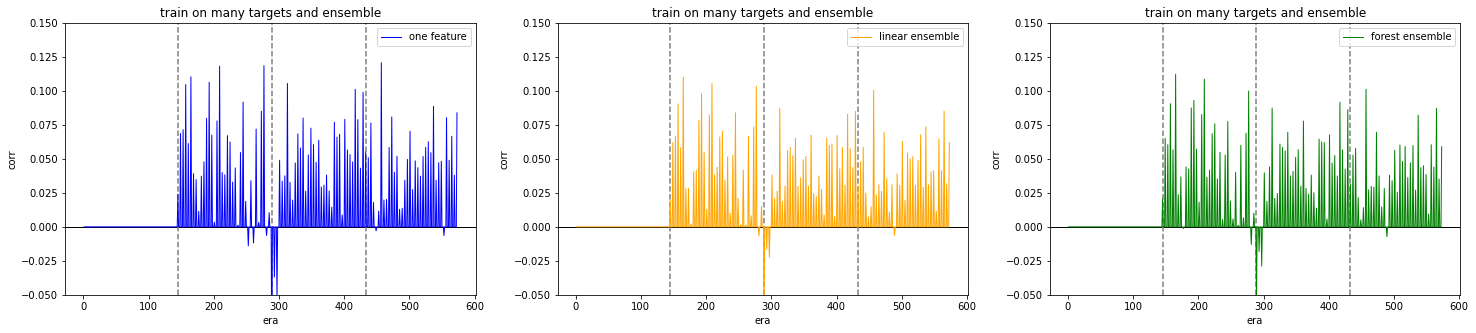

In [50]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
# ax1.axhline(0, color='black', linewidth=1)
# ax2.axhline(0, color='black', linewidth=1)
# ax3.axhline(0, color='black', linewidth=1)
# for e in e_val_min:
#     ax1.axvline(e, color='gray', linestyle='--')
#     ax2.axvline(e, color='gray', linestyle='--')
#     ax3.axvline(e, color='gray', linestyle='--')
# ax1.plot(eras, corr_dict_era['corr_one'], color='blue'  , linewidth=1, label='one feature')
# ax2.plot(eras, corr_dict_era['corr_lin'], color='orange', linewidth=1, label='linear ensemble')
# ax3.plot(eras, corr_dict_era['corr_lgb'], color='green' , linewidth=1, label='forest ensemble')
# ax1.set_ylim(-0.05, 0.15)
# ax2.set_ylim(-0.05, 0.15)
# ax3.set_ylim(-0.05, 0.15)
# ax1.set_xlabel('era')
# ax1.set_ylabel('corr')
# ax1.set_title(f'train on many targets and ensemble')
# ax1.legend()
# ax2.set_xlabel('era')
# ax2.set_ylabel('corr')
# ax2.set_title(f'train on many targets and ensemble')
# ax2.legend()
# ax3.set_xlabel('era')
# ax3.set_ylabel('corr')
# ax3.set_title(f'train on many targets and ensemble')
# ax3.legend()

In [53]:
# corr_df_fold = pd.DataFrame(corr_dict_fold)

# CV 3: Feature neutralization

In [51]:
# params = {
#     'n_estimators': 2000,
#     'learning_rate': 0.01,
#     'max_depth': 5,
#     'num_leaves': 2**5,
#     'colsample_bytree': 0.1,
#     'device': 'gpu',
# }

# df = pd.read_parquet('data/train.parquet', columns=COLUMNS)
# df[ERA] = df[ERA].astype('int32')
# df = df.fillna(0.5)

# X_COLS = FEAT_L

# X = df[X_COLS]
# y = df[Y_TRUE]
# e = df[ERA]

# del df
# gc.collect()

# spl = TimeSeriesSplitGroups()

# model = LGBMRegressor(**params)
# model = EraSubsampler(model)
# model = FeatureNeutralizer(model, n_features=5, alpha=1)

In [52]:
# feat_numbers = [5, 10, 25, 50, 100]
# alphas = np.arange(0, 1, 0.01)

# i = 0
# for trn, val in spl.split(X, y, e):
#     i += 1
#     print(f'in iteration {i}/5 of CV')
#     X_val = X.iloc[val]
#     X_trn = X.iloc[trn]
#     y_val = y.iloc[val]
#     y_trn = y.iloc[trn]
#     e_val = e.iloc[val]
#     e_trn = e.iloc[trn]

#     print('\ttraining model')
#     model.fit(X_trn, y_trn, eras=e_trn)
#     joblib.dump(model, f'model-0/saved-variables/model_neut_{i}')

#     print('\tcomputing y_pred')
#     model.compute_y_pred(X_val)
#     joblib.dump(model, f'model-0/saved-variables/model_neut_{i}')

#     print('\tcomputing corrs')
#     for n_feats in feat_numbers:
#         model.set_params(n_features=n_feats)
#         model.compute_y_linr(X_val, groups=e_val)
#         corrs = [(corr(y_val, model.y_pred - a * model.y_linr, rank_a=e_val), a) for a in alphas]
#         c, a = sorted(corrs, reverse=True)[0]
#         print(f'\t\tCV_fold = {i}, n_features = {n_feats}, a = {a:.2f}, c = {c:.4f}')
